In [12]:
# import numpy as np
# from collections import Counter

# class Node:
#     def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
#         self.feature = feature
#         self.threshold = threshold
#         self.left = left
#         self.right = right
#         self.value = value
        
#     def is_leaf_node(self):
#         return self.value is not None


# class DecisionTree:
#     def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
#         self.min_samples_split=min_samples_split
#         self.max_depth=max_depth
#         self.n_features=n_features
#         self.root=None

#     def fit(self, X, y):
#         self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)#choose min num of features , could be helpful in random forests
#         self.root = self.grow_treee(X, y) 
        
#     def grow_treee(self,X,y,maxDepth=0):
#         n_samples = X.shape[0]
#         n_feats = X.shape[1]
#         n_labels = len(np.unique(y))
#         #check stopping critera , if ok keep expanding , if not return root
#         if(maxDepth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
#             prediction = self.mostCommonLabell(y)
#             #prediction is the leaf value (0,1)
#             return Node(value=prediction)
        
#         #find best split
        
#         #args:totalNumFeats,numOfFeatsWeWantToSelect,unique feats only  
#         featIDXs = np.random.choice(n_feats,self.n_features,replace=False)
#         bestFeatureForSplit,bestThresoldForSplit = self.bestSplitt(X,y,featIDX=featIDXs)
#         left_idxs, right_idxs = self.splitt(X[:, bestFeatureForSplit], bestThresoldForSplit)
#         #create child node (recursive call)
#         left = self.grow_treee(X[left_idxs, :], y[left_idxs], maxDepth+1)
#         right = self.grow_treee(X[right_idxs, :], y[right_idxs], maxDepth+1)
#         return Node(bestFeatureForSplit, bestThresoldForSplit, left, right)
#     def mostCommonLabell(self,y):#get most frequent label of dataset
#         counter = Counter(y)
#         return counter.most_common(1)[0][0]#return label of most common elem in set
    
#     def bestSplitt(self,X,y,featIDX):
#         #returns best feature to split on and its thresold
#         best_info_gain = -1
#         split_idx , split_thresold = None,None
    
#         for fi in featIDX: 
#             X_col = X[:,fi]
#             thresolds = np.unique(X_col)
#             for ti in thresolds:
#                 #calc infogain and choose best one 
#                 gain = self.calcInfoGainn(y,X_col,ti) 
#                 if gain>best_info_gain:
#                     best_info_gain = gain
#                     split_idx = fi
#                     split_thresold = ti
                    
#         return split_idx,split_thresold
#     def calcInfoGainn(self,y,X_col,thresold_i):
#         # IG = entropy(parent) - weightedAvg*entropy(children)
#         #entropy = -sigma( p(x) * log2( p(x) )   )
#         parent_entropy = self.calcEntropyy(y)
        
#         leftIDX , rightIDX = self.splitt(X_col,thresold_i)
#         if(len(leftIDX)==0 or len(rightIDX)==0):
#             return 0
        
#         #weighted entropy 
#         nTotal = len(y)
#         nRight = len(rightIDX)
#         nLeft = len(leftIDX)
#         entropyLeft = self.calcEntropyy(y[leftIDX])
#         entropyRight = self.calcEntropyy(y[rightIDX])
#         childEntropy = ((nLeft)/nTotal) * entropyLeft + ((nRight)/nTotal) * entropyRight
        
#         #ex: 
#         # After split: age <= 30
# # Left child:  60 samples, entropy = 0.8  (mixed: [35 class-0, 25 class-1])
# # Right child: 40 samples, entropy = 0.3  (pure:  [5 class-0, 35 class-1])

# # We can't just average: (0.8 + 0.3) / 2 = 0.55  
# # The left child has MORE samples, so it should count more:

# # childEntropy = (60/100) * 0.8 + (40/100) * 0.3
#             #  = 0.6 * 0.8 + 0.4 * 0.3
#             #  = 0.48 + 0.12
#             #  = 0.60 
        
#         #calc ig
#         infoGain = parent_entropy - childEntropy
#         return infoGain 
        
#     def calcEntropyy(self,y):
#         hist=np.bincount(y)
#         #np.bincount : input ([1,2,3,1,2]) , Output : ([0,2,2,1]) 
#         probabilitiess = hist/len(y) #get all probabilities of each label
#         #entropy = -sigma( p(x) * log2( p(x) )   )
#         return   -np.sum([p*np.log(p) for p in probabilitiess if p>0])#avoid log(0)
        
#     def splitt(self,X_col,thresold_i):
#         #np.argwhere : returns indices of all elements that fulfill a condition
#         left_idx = np.argwhere(X_col<=thresold_i).flatten()
#         right_idx = np.argwhere(X_col>thresold_i).flatten()
        
#         return left_idx,right_idx
#     def singleTreePredict(self, X):
#         return np.array([self._traverse_tree(x, self.root) for x in X])

#     def _traverse_tree(self, x, node):
#         if node.is_leaf_node():
#             return node.value

#         if x[node.feature] <= node.threshold:
#             return self._traverse_tree(x, node.left)
#         return self._traverse_tree(x, node.right)
        
        

In [13]:
# from sklearn import datasets
# from sklearn.model_selection import train_test_split

# data = datasets.load_breast_cancer()
# X, y = data.data, data.target

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=1234
# )

# clf = DecisionTree(max_depth=10)
# clf.fit(X_train, y_train)
# predictions = clf.singleTreePredict(X_test)

# def accuracy(y_test, y_pred):
#     return np.sum(y_test == y_pred) / len(y_test)

# acc = accuracy(y_test, predictions)
# print(acc)

In [14]:
import numpy as np
from collections import Counter
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def singleTreefit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)#choose min num of features , could be helpful in random forests
        self.root = self.grow_treee(X, y) 
        
    def grow_treee(self,X,y,maxDepth=0):
        n_samples = X.shape[0]
        n_feats = X.shape[1]
        n_labels = len(np.unique(y))
        #check stopping critera , if ok keep expanding , if not return root
        if(maxDepth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            prediction = self.mostCommonLabell(y)
            #prediction is the leaf value (0,1)
            return Node(value=prediction)
        
        #find best split
        
        #args:totalNumFeats,numOfFeatsWeWantToSelect,unique feats only,no replacement  
        featIDXs = np.random.choice(n_feats,self.n_features,replace=False)
        bestFeatureForSplit,bestThresoldForSplit = self.bestSplitt(X,y,featIDX=featIDXs)
        left_idxs, right_idxs = self.splitt(X[:, bestFeatureForSplit], bestThresoldForSplit)
        #create child node (recursive call)
        left = self.grow_treee(X[left_idxs, :], y[left_idxs], maxDepth+1)
        right = self.grow_treee(X[right_idxs, :], y[right_idxs], maxDepth+1)
        return Node(bestFeatureForSplit, bestThresoldForSplit, left, right)
        
    def mostCommonLabell(self,y):#get most frequent label of dataset
        counter = Counter(y)
        return counter.most_common(1)[0][0]#return label of most common elem in set
    
    def bestSplitt(self,X,y,featIDX):
        #returns best feature to split on and its thresold
        best_info_gain = -1
        split_idx , split_thresold = None,None
    
        for fi in featIDX: 
            X_col = X[:,fi]
            # C3: Consider thresholds between sorted distinct feature values
            unique_vals = np.unique(X_col)
            # Generate thresholds as midpoints between consecutive unique values
            if len(unique_vals) > 1:
                thresolds = (unique_vals[:-1] + unique_vals[1:]) / 2
            else:
                thresolds = unique_vals
                
            for ti in thresolds:
                #calc infogain and choose best one 
                gain = self.calcInfoGainn(y,X_col,ti) 
                if gain>best_info_gain:
                    best_info_gain = gain
                    split_idx = fi
                    split_thresold = ti
                    
        return split_idx,split_thresold
        
    def calcInfoGainn(self,y,X_col,thresold_i):
        # IG = entropy(parent) - weightedAvg*entropy(children)
        #entropy = -sigma( p(x) * log2( p(x) )   )
        parent_entropy = self.calcEntropyy(y)
        
        leftIDX , rightIDX = self.splitt(X_col,thresold_i)
        if(len(leftIDX)==0 or len(rightIDX)==0):
            return 0
        
        #weighted entropy 
        nTotal = len(y)
        nRight = len(rightIDX)
        nLeft = len(leftIDX)
        entropyLeft = self.calcEntropyy(y[leftIDX])
        entropyRight = self.calcEntropyy(y[rightIDX])
        childEntropy = ((nLeft)/nTotal) * entropyLeft + ((nRight)/nTotal) * entropyRight
        
        #ex: 
        # After split: age <= 30
# Left child:  60 samples, entropy = 0.8  (mixed: [35 class-0, 25 class-1])
# Right child: 40 samples, entropy = 0.3  (pure:  [5 class-0, 35 class-1])

# We can't just average: (0.8 + 0.3) / 2 = 0.55  
# The left child has MORE samples, so it should count more:

# childEntropy = (60/100) * 0.8 + (40/100) * 0.3
            #  = 0.6 * 0.8 + 0.4 * 0.3
            #  = 0.48 + 0.12
            #  = 0.60 
        
        #calc ig
        infoGain = parent_entropy - childEntropy
        return infoGain 
        
    def calcEntropyy(self,y):
        hist=np.bincount(y)
        #np.bincount : input ([1,2,3,1,2]) , Output : ([0,2,2,1]) 
        probabilitiess = hist/len(y) #get all probabilities of each label
        #entropy = -sigma( p(x) * log2( p(x) )   )
        return   -np.sum([p*np.log(p) for p in probabilitiess if p>0])#avoid log(0)
        
    def splitt(self,X_col,thresold_i):
        #np.argwhere : returns indices of all elements that fulfill a condition
        left_idx = np.argwhere(X_col<=thresold_i).flatten()
        right_idx = np.argwhere(X_col>thresold_i).flatten()
        
        return left_idx,right_idx
        
    def singleTreePredict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)
    
    def accuracy(self, y_true, y_pred):
        return np.sum(y_true == y_pred) / len(y_true)


# C1: Dataset and setup
def load_and_split_data():
    """Load breast cancer dataset and split into train/validation/test sets (70%/15%/15%)"""
    data = load_breast_cancer()
    X, y = data.data, data.target
    
    # First split: 70% train, 30% temp (validation + test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Second split: 50% of temp for validation, 50% for test (15% each of original)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )
    
    return X_train, X_val, X_test, y_train, y_val, y_test, data.feature_names


# C4: Hyperparameter tuning and analysis
def hyperparameter_tuning(X_train, y_train, X_val, y_val):
    """Explore different hyperparameter combinations and select the best one"""
    max_depths = [2, 4, 6, 8, 10]
    min_samples_splits = [2, 5, 10]
    
    best_accuracy = 0
    best_params = {}
    results = {}
    
    print("Hyperparameter Tuning Results:")
    print("max_depth | min_samples_split | Validation Accuracy")
    print("-" * 50)
    
    for max_depth in max_depths:
        results[max_depth] = {}
        for min_samples_split in min_samples_splits:
            # Train model with current hyperparameters
            tree = DecisionTree(max_depth=max_depth, min_samples_split=min_samples_split)
            tree.singleTreefit(X_train, y_train)
            
            # Predict on validation set
            y_pred = tree.singleTreePredict(X_val)
            accuracy = tree.accuracy(y_val, y_pred)
            
            results[max_depth][min_samples_split] = accuracy
            
            print(f"{max_depth:9} | {min_samples_split:17} | {accuracy:.4f}")
            
            # Update best parameters if current model is better
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'max_depth': max_depth, 'min_samples_split': min_samples_split}
    
    print(f"\nBest parameters: {best_params} with validation accuracy: {best_accuracy:.4f}")
    return best_params, results


def analyze_depth_vs_accuracy(X_train, y_train, X_val, y_val, fixed_min_samples_split=2):
    """Analyze how training and validation accuracy change with max_depth"""
    max_depths = [2, 4, 6, 8, 10]
    train_accuracies = []
    val_accuracies = []
    
    print(f"\nAnalysis with fixed min_samples_split={fixed_min_samples_split}:")
    print("max_depth | Train Accuracy | Validation Accuracy")
    print("-" * 50)
    
    for max_depth in max_depths:
        # Train model
        tree = DecisionTree(max_depth=max_depth, min_samples_split=fixed_min_samples_split)
        tree.singleTreefit(X_train, y_train)
        
        # Calculate training accuracy
        y_train_pred = tree.singleTreePredict(X_train)
        train_acc = tree.accuracy(y_train, y_train_pred)
        train_accuracies.append(train_acc)
        
        # Calculate validation accuracy
        y_val_pred = tree.singleTreePredict(X_val)
        val_acc = tree.accuracy(y_val, y_val_pred)
        val_accuracies.append(val_acc)
        
        print(f"{max_depth:9} | {train_acc:.4f}         | {val_acc:.4f}")
    
    return max_depths, train_accuracies, val_accuracies


def plot_depth_vs_accuracy(max_depths, train_accuracies, val_accuracies):
    """Plot training and validation accuracy vs max_depth"""
    plt.figure(figsize=(10, 6))
    plt.plot(max_depths, train_accuracies, 'b-', label='Training Accuracy', marker='o')
    plt.plot(max_depths, val_accuracies, 'r-', label='Validation Accuracy', marker='o')
    plt.xlabel('Max Depth')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy vs Max Depth')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(max_depths)
    plt.show()




# RANDOM FOREST : PART D

In [15]:
class RandomForest:
    def __init__(self,numOfTrees=10,maxDepth=10,minSamplesSplit=2,numberOfFeatures=None):
        self.numOfTrees = numOfTrees
        self.maxDepth = maxDepth
        self.minSamplesSplit = minSamplesSplit
        self.numberOfFeatures = numberOfFeatures
        self.trees = []
        
    
    def fit(self,X,y):
        for i in range(self.numOfTrees):
            tree=DecisionTree(max_depth=self.maxDepth,min_samples_split=self.minSamplesSplit,n_features=self.numberOfFeatures)

            X_sample , y_sample = self.randomPartition(X,y)
            
            tree.singleTreefit(X_sample,y_sample) #fit this tree 
            self.trees.append(tree)
            
    def predict(self,X):
      
    #    predictions = [[1, 0, 1, 0],    # tree 1 predictions
    #                   [1, 1, 1, 0],    # tree 2 predictions  
    #                   [0, 1, 1, 0]]    # tree 3 predictions
    #                               3*4 
       
    #    Step 2 - swap axes:
    #    treePredictions = [[1, 1, 0],   # sample 1: votes from all 3 trees
    #                       [0, 1, 1],   # sample 2: votes from all 3 trees
    #                       [1, 1, 1],   # sample 3: votes from all 3 trees
    #                       [0, 0, 0]]   # sample 4: votes from all 3 trees
    #                                4*3   
       
    #    Step 3 - majority vote:
    #    final_predictions = [1, 1, 1, 0]  # most common vote for each sample
       
       predictions=np.array([t.singleTreePredict(X) for t in self.trees]) 
        # np arr [ [tre1predict],[t2predict],... ]
       treePredictions=np.swapaxes(predictions,0,1)
       return np.array([self.mostCommonLabell(p) for p in treePredictions])
    def mostCommonLabell(self,y):#get most frequent label of dataset
        counter = Counter(y)
        return counter.most_common(1)[0][0]#return label of most common elem in set
    
    def randomPartition(self,X,y):
        n_samples = X.shape[0]
        idxs=np.random.choice(n_samples,size=n_samples,replace=True)#choose with replacement 
        return X[idxs],y[idxs]
        
def random_forest_hyperparameter_tuning(X_train, y_train, X_val, y_val, best_single_tree_params):
    """
    Explore different Random Forest hyperparameter combinations
    Uses best params from Part C for individual trees
    """
    num_trees_options = [5, 10, 30, 50]
    n_features = X_train.shape[1]
    max_features_options = [int(np.sqrt(n_features)), int(n_features/2)]  # [√d, d/2]
    
    best_accuracy = 0
    best_rf_params = {}
    results = {}
    
    print("="*60)
    print("D3: Random Forest Hyperparameter Tuning")
    print("="*60)
    print(f"Using best single tree params from Part C:")
    print(f"  max_depth = {best_single_tree_params['max_depth']}")
    print(f"  min_samples_split = {best_single_tree_params['min_samples_split']}")
    print(f"\nNumber of features in dataset: {n_features}")
    print(f"Testing max_features: {max_features_options}")
    print("\n" + "-"*70)
    print("num_trees | max_features | Validation Accuracy | Time (seconds)")
    print("-"*70)
    
    for num_trees in num_trees_options:
        results[num_trees] = {}
        for max_features in max_features_options:
            import time
            start_time = time.time()
            
            # Train Random Forest
            rf = RandomForest(
                numOfTrees=num_trees,
                maxDepth=best_single_tree_params['max_depth'],
                minSamplesSplit=best_single_tree_params['min_samples_split'],
                numberOfFeatures=max_features
            )
            rf.fit(X_train, y_train)
            
            # Predict on validation set
            y_pred = rf.predict(X_val)
            accuracy = np.sum(y_val == y_pred) / len(y_val)
            
            elapsed_time = time.time() - start_time
            results[num_trees][max_features] = accuracy
            
            print(f"{num_trees:9} | {max_features:12} | {accuracy:.4f}              | {elapsed_time:.2f}")
            
            # Update best parameters
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_rf_params = {
                    'num_trees': num_trees,
                    'max_features': max_features,
                    'max_depth': best_single_tree_params['max_depth'],
                    'min_samples_split': best_single_tree_params['min_samples_split']
                }
    
    print("-"*70)
    print(f"\nBest Random Forest parameters:")
    print(f"  num_trees = {best_rf_params['num_trees']}")
    print(f"  max_features = {best_rf_params['max_features']}")
    print(f"  Validation accuracy: {best_accuracy:.4f}")
    
    return best_rf_params, results


def compare_single_tree_vs_random_forest(X_train, y_train, X_val, y_val, X_test, y_test, 
                                         best_single_tree_params, best_rf_params):
    """
    Compare performance of single decision tree vs random forest
    Analyze bias and variance
    """
    print("\n" + "="*60)
    print("D3: Single Tree vs Random Forest Comparison")
    print("="*60)
    
    # Combine training and validation for final models
    X_train_val = np.vstack([X_train, X_val])
    y_train_val = np.concatenate([y_train, y_val])
    
    # Train single decision tree
    print("\nTraining Single Decision Tree...")
    single_tree = DecisionTree(
        max_depth=best_single_tree_params['max_depth'],
        min_samples_split=best_single_tree_params['min_samples_split']
    )
    single_tree.singleTreefit(X_train_val, y_train_val)
    
    # Train random forest
    print(f"Training Random Forest with {best_rf_params['num_trees']} trees...")
    rf = RandomForest(
        numOfTrees=best_rf_params['num_trees'],
        maxDepth=best_rf_params['max_depth'],
        minSamplesSplit=best_rf_params['min_samples_split'],
        numberOfFeatures=best_rf_params['max_features']
    )
    rf.fit(X_train_val, y_train_val)
    
    # Evaluate both models
    print("\n" + "-"*60)
    print("Performance Comparison on Test Set:")
    print("-"*60)
    
    # Single tree predictions
    y_train_pred_tree = single_tree.singleTreePredict(X_train_val)
    y_test_pred_tree = single_tree.singleTreePredict(X_test)
    train_acc_tree = np.sum(y_train_val == y_train_pred_tree) / len(y_train_val)
    test_acc_tree = np.sum(y_test == y_test_pred_tree) / len(y_test)
    
    # Random forest predictions
    y_train_pred_rf = rf.predict(X_train_val)
    y_test_pred_rf = rf.predict(X_test)
    train_acc_rf = np.sum(y_train_val == y_train_pred_rf) / len(y_train_val)
    test_acc_rf = np.sum(y_test == y_test_pred_rf) / len(y_test)
    
    print(f"\nSingle Decision Tree:")
    print(f"  Training Accuracy: {train_acc_tree:.4f}")
    print(f"  Test Accuracy:     {test_acc_tree:.4f}")
    print(f"  Overfitting Gap:   {train_acc_tree - test_acc_tree:.4f}")
    
    print(f"\nRandom Forest:")
    print(f"  Training Accuracy: {train_acc_rf:.4f}")
    print(f"  Test Accuracy:     {test_acc_rf:.4f}")
    print(f"  Overfitting Gap:   {train_acc_rf - test_acc_rf:.4f}")
    
    print(f"\nImprovement (Random Forest - Single Tree):")
    print(f"  Test Accuracy Improvement: {test_acc_rf - test_acc_tree:.4f}")
    print(f"  Reduction in Overfitting:  {(train_acc_tree - test_acc_tree) - (train_acc_rf - test_acc_rf):.4f}")
    
    # Analysis of Bias and Variance
    print("\n" + "-"*60)
    print("Bias-Variance Analysis:")
    print("-"*60)
    
    if train_acc_tree - test_acc_tree > 0.05:
        print("\nSingle Tree: Shows HIGH VARIANCE (overfitting)")
        print("  - Large gap between training and test accuracy")
        print("  - Model memorizes training data too well")
    else:
        print("\nSingle Tree: Shows LOW VARIANCE")
    
    if train_acc_rf - test_acc_rf < train_acc_tree - test_acc_tree:
        print("\nRandom Forest: REDUCES VARIANCE through ensemble")
        print("  - Averaging multiple trees reduces overfitting")
        print("  - More stable predictions")
        print("  - Better generalization to unseen data")
    
    if test_acc_rf > test_acc_tree:
        print(f"\nRandom Forest achieves {(test_acc_rf - test_acc_tree)*100:.2f}% better test accuracy")
        print("This demonstrates the power of ensemble learning!")
    
    return {
        'single_tree': {'train_acc': train_acc_tree, 'test_acc': test_acc_tree},
        'random_forest': {'train_acc': train_acc_rf, 'test_acc': test_acc_rf}
    }


def plot_random_forest_results(results_dict):
    """Plot Random Forest hyperparameter tuning results"""
    num_trees_list = sorted(results_dict.keys())
    max_features_list = sorted(set(feat for tree_results in results_dict.values() 
                                   for feat in tree_results.keys()))
    
    plt.figure(figsize=(12, 6))
    
    for max_feat in max_features_list:
        accuracies = [results_dict[nt].get(max_feat, 0) for nt in num_trees_list]
        plt.plot(num_trees_list, accuracies, marker='o', linewidth=2, 
                label=f'max_features={max_feat}')
    
    plt.xlabel('Number of Trees', fontsize=12)
    plt.ylabel('Validation Accuracy', fontsize=12)
    plt.title('Random Forest: Validation Accuracy vs Number of Trees', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(num_trees_list)
    plt.tight_layout()
    plt.show()



Loading Breast Cancer Wisconsin dataset...
Training set size: 398
Validation set size: 85
Test set size: 86
Number of features: 30
Feature names: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Class distribution in training set: [148 250]

C4: Hyperparameter Tuning
Hyperparameter Tuning Results:
max_depth | min_samples_split | Validation Accuracy
--------------------------------------------------
        2 |                 2 | 0.9176
        2 |                 2 | 0.9176
        2 |   

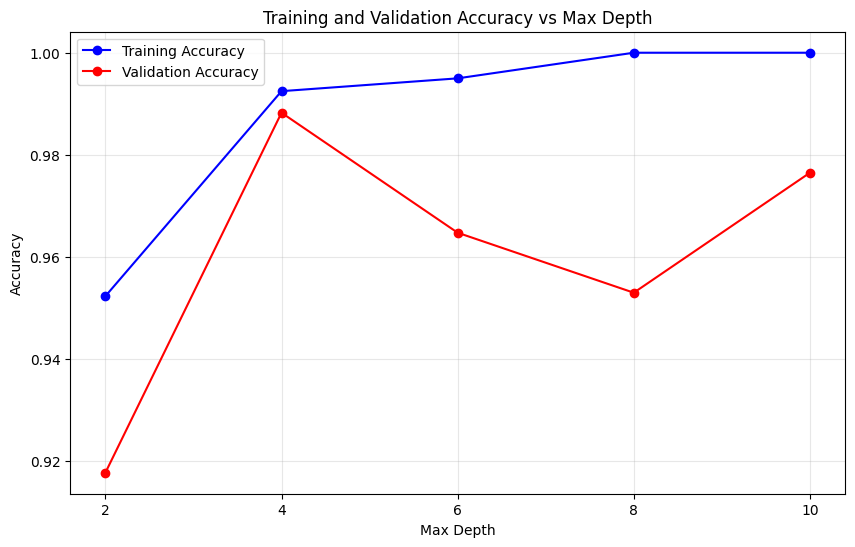


C4: Final Model Evaluation
Final model performance on test set:
Best parameters: max_depth=4, min_samples_split=2
Test accuracy: 0.8837
Baseline accuracy (majority class): 0.6279
Improvement over baseline: 0.2558
D3: Random Forest Hyperparameter Tuning
Using best single tree params from Part C:
  max_depth = 4
  min_samples_split = 2

Number of features in dataset: 30
Testing max_features: [5, 15]

----------------------------------------------------------------------
num_trees | max_features | Validation Accuracy | Time (seconds)
----------------------------------------------------------------------
Final model performance on test set:
Best parameters: max_depth=4, min_samples_split=2
Test accuracy: 0.8837
Baseline accuracy (majority class): 0.6279
Improvement over baseline: 0.2558
D3: Random Forest Hyperparameter Tuning
Using best single tree params from Part C:
  max_depth = 4
  min_samples_split = 2

Number of features in dataset: 30
Testing max_features: [5, 15]

----------------

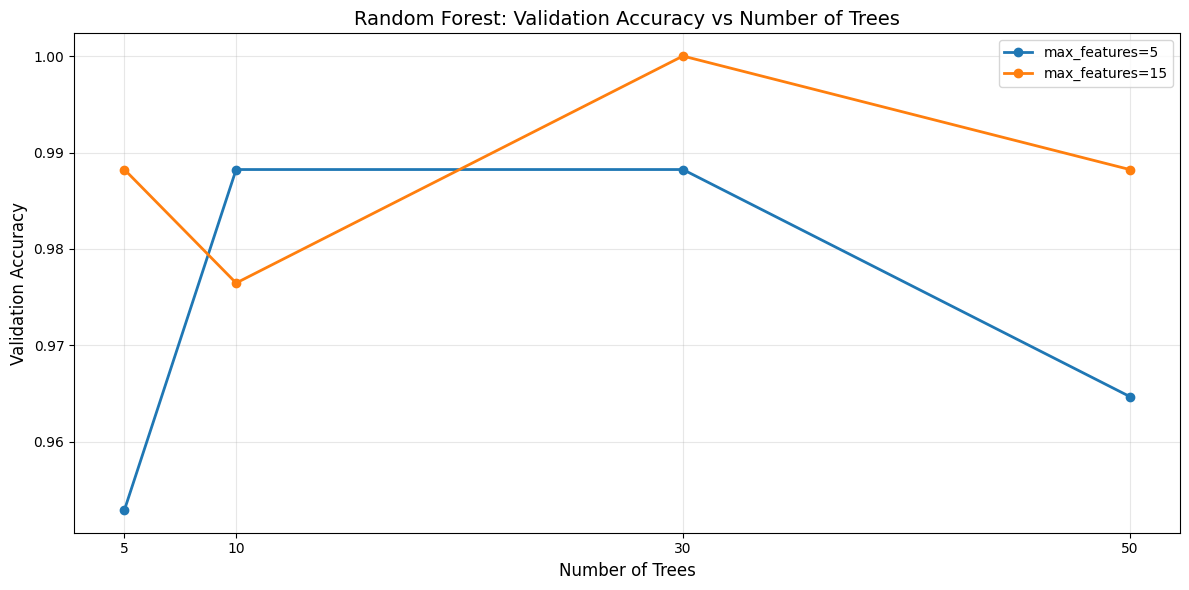


D3: Single Tree vs Random Forest Comparison

Training Single Decision Tree...
Training Random Forest with 30 trees...
Training Random Forest with 30 trees...

------------------------------------------------------------
Performance Comparison on Test Set:
------------------------------------------------------------

Single Decision Tree:
  Training Accuracy: 0.9917
  Test Accuracy:     0.8837
  Overfitting Gap:   0.1080

Random Forest:
  Training Accuracy: 0.9917
  Test Accuracy:     0.9186
  Overfitting Gap:   0.0731

Improvement (Random Forest - Single Tree):
  Test Accuracy Improvement: 0.0349
  Reduction in Overfitting:  0.0349

------------------------------------------------------------
Bias-Variance Analysis:
------------------------------------------------------------

Single Tree: Shows HIGH VARIANCE (overfitting)
  - Large gap between training and test accuracy
  - Model memorizes training data too well

Random Forest: REDUCES VARIANCE through ensemble
  - Averaging multiple

In [16]:
def main():
    # C1: Load and split data
    print("Loading Breast Cancer Wisconsin dataset...")
    X_train, X_val, X_test, y_train, y_val, y_test, feature_names = load_and_split_data()
    
    print(f"Training set size: {X_train.shape[0]}")
    print(f"Validation set size: {X_val.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}")
    print(f"Number of features: {X_train.shape[1]}")
    print(f"Feature names: {feature_names}")
    print(f"Class distribution in training set: {np.bincount(y_train)}")
    
    # C4: Hyperparameter tuning
    print("\n" + "="*60)
    print("C4: Hyperparameter Tuning")
    print("="*60)
    
    best_params, tuning_results = hyperparameter_tuning(X_train, y_train, X_val, y_val)
    
    # C4: Analyze depth vs accuracy with fixed min_samples_split
    print("\n" + "="*60)
    print("C4: Depth vs Accuracy Analysis")
    print("="*60)
    
    max_depths, train_accuracies, val_accuracies = analyze_depth_vs_accuracy(
        X_train, y_train, X_val, y_val, fixed_min_samples_split=2
    )
    
    # Plot the results
    plot_depth_vs_accuracy(max_depths, train_accuracies, val_accuracies)
    
    # C4: Retrain on training + validation with best parameters and evaluate on test set
    print("\n" + "="*60)
    print("C4: Final Model Evaluation")
    print("="*60)
    
    # Combine training and validation sets
    X_train_val = np.vstack([X_train, X_val])
    y_train_val = np.concatenate([y_train, y_val])
    
    # Train final model with best parameters
    final_tree = DecisionTree(
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split']
    )
    final_tree.singleTreefit(X_train_val, y_train_val)
    
    # Evaluate on test set
    y_test_pred = final_tree.singleTreePredict(X_test)
    test_accuracy = final_tree.accuracy(y_test, y_test_pred)
    
    print(f"Final model performance on test set:")
    print(f"Best parameters: max_depth={best_params['max_depth']}, "
          f"min_samples_split={best_params['min_samples_split']}")
    print(f"Test accuracy: {test_accuracy:.4f}")
    
    # Compare with baseline (majority class)
    majority_class = np.argmax(np.bincount(y_train_val))
    baseline_accuracy = np.sum(y_test == majority_class) / len(y_test)
    print(f"Baseline accuracy (majority class): {baseline_accuracy:.4f}")
    print(f"Improvement over baseline: {test_accuracy - baseline_accuracy:.4f}")
    
    # ========== PART D: RANDOM FOREST ==========
    
    # D3: Random Forest Hyperparameter Tuning
    best_rf_params, rf_tuning_results = random_forest_hyperparameter_tuning(
        X_train, y_train, X_val, y_val, best_params
    )
    
    # Plot Random Forest results
    plot_random_forest_results(rf_tuning_results)
    
    # D3: Compare Single Tree vs Random Forest
    comparison_results = compare_single_tree_vs_random_forest(
        X_train, y_train, X_val, y_val, X_test, y_test,
        best_params, best_rf_params
    )
    
    print("\n" + "="*60)
    print("Analysis Complete!")
    print("="*60)


if __name__ == "__main__":
    main()